### Audio Classification in Pytorch
This notebook describes the steps taken in realizing a Convolutional Neural Network (CNN), usable for classification in audio classification. The goal is to research the use of CNNs in audio classification and how to go about preprocessing audio data to make it useful for training a model. 

#### 1. Introduction
This assignment aims to solve the following problem:

"The company SLIFTS (Smart Lifts in Floor Transition Systems) want to expand its elevator capabilities to handle spoken commands. In the aftermath of the global 2020 COVID pandemic, the company has noted a sharp decline in the number of passengers that use their elevators. Marketing research has shown that people are hesitant to touch physical buttons in the elevator. As one user noted “this up-button looks really yucky, I can almost see the germs crawling on it!”. The situation is extremely serious and people are even doing previously unthinkable things like taking the stairs, which has to be prevented in all cases. To resolve this problem, SLIFTS has hired Zuyd Hogeschool to research and develop elevators with voice command capabilities."

To solve this problem, the following points will be looked at closely:
1. Preprocessing audio data for training a CNN
2. Preparing the dataset for training. This includes making decisions on splitting the dataset.
3. Designing the model.
4. Implementing the model for training.
5. Evaluating the output of the model after training.
6. Finetuning the model after evaluating the results.

Note that the advisory and conclusion is included in a separate document.

#### 2. Data Collection
For any machine learning/ai project, a dataset is needed to train, test and evaluate a model once it's built in code. In the case of recognizing speech commands, a dataset is needed where these speech commands, like 'yes' or 'down', need to be made audible. Fortunately, such a dataset is already available on [Kaggle](https://www.kaggle.com/datasets/antfilatov/mini-speech-commands/data).

This dataset includes the following commands: down, go, left, no, right, stop, up, yes.

In [1]:
'''To make a custom dataset, a class will be made that inherits its properties
from the pytorch dataset class'''
import os 
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio
from torch import nn
import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Audio, display

class LiftCommandDataset(Dataset):
    def __init__(self, root_dir: str, transform=None):
        self.root_dir = root_dir
        self.file_paths = []
        self.labels = []
        self.label_map = {}
        self.transform = transform

        '''Recursively load all files and append corresponding labels from folder name'''
        '''Please optimize :('''
        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                self.label_map[label] = len(self.label_map)
                for file_name in os.listdir(label_dir):
                    if file_name.endswith('.wav'):
                        self.file_paths.append(os.path.join(label_dir, file_name))
                        self.labels.append(self.label_map[label])
        print("Label Map:", self.label_map, "\n")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index: int):
        file_path = self.file_paths[index]
        waveform, sample_rate = torchaudio.load(file_path)

        if self.transform:
            waveform = self.transform(waveform)
        
        label = self.labels[index]
        return waveform, label
    

"""         audio_path = self.file_paths[index]
        label = self.labels[index]

        waveform= torchaudio.load(audio_path, normalize=True)

        if waveform.size(0) > 1:
            waveform = waveform[0:1, :]

        if waveform.dim() > 1:
            waveform = waveform.squeeze(0)
        
        if self.transform:
            waveform = self.transform(waveform)

        return waveform, label """


'         audio_path = self.file_paths[index]\n        label = self.labels[index]\n\n        waveform= torchaudio.load(audio_path, normalize=True)\n\n        if waveform.size(0) > 1:\n            waveform = waveform[0:1, :]\n\n        if waveform.dim() > 1:\n            waveform = waveform.squeeze(0)\n\n        if self.transform:\n            waveform = self.transform(waveform)\n\n        return waveform, label '

#### 3. Data Preprocessing


To make audio file formats usable for training a CNN, they will need to be converted to an image of some sort. For the given problem, there are two options to achieve this:
1. Mel-spectrogram: full time-frequency representation of an audio signal
2. Mel-frequency Cepstral Coefficients (MFCC): reduced set of coefficients that summarize the spectral characteristics.

Both frequencies make use of the Mel scale, which is a scale of the pitches that approximately represent the way humans perceive sound. The Mel-spectrogram however captures a full time-frequency representation of the audio signal, while Mel-frequency only captures the most important characteristics of the audio signal.

For this project, Mel-spectrogram will be used since it might give the model more opportunities to understand underlying patterns.

In [2]:
import torchaudio.transforms as T

transform = T.MelSpectrogram(sample_rate=16000, n_mels=64, n_fft=400, hop_length=160)

In [3]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

In [4]:
waveform, sample_rate = torchaudio.load("./mini_speech_commands/down/0a9f9af7_nohash_0.wav")

print_stats(waveform, sample_rate=sample_rate)

Sample Rate: 16000
Shape: (1, 13654)
Dtype: torch.float32
 - Max:      0.115
 - Min:     -0.225
 - Mean:     0.003
 - Std Dev:  0.030

tensor([[0.0018, 0.0030, 0.0028,  ..., 0.0253, 0.0297, 0.0178]])



In [5]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

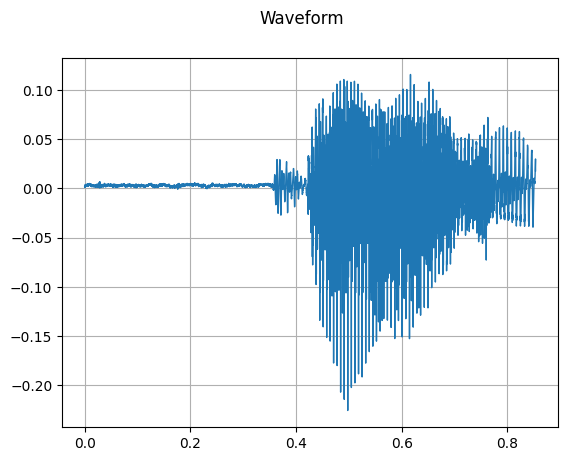

In [6]:
plot_waveform(waveform, sample_rate)

In [7]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

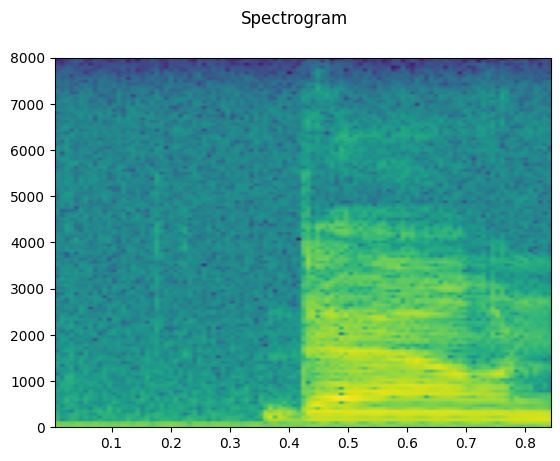

In [8]:
plot_specgram(waveform, sample_rate)

In [9]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

In [10]:
play_audio(waveform, sample_rate)

In [11]:
'''Function that can be useful for splitting the dataset'''
def testval_split(dataset, train_size: float):
    '''Set the parameters for making the random split'''
    dataset_size = len(dataset)
    train_data = int(train_size * dataset_size)
    val_data = dataset_size - train_data

    train_dataset, val_dataset = random_split(dataset, [train_data, val_data])
    
    return train_dataset, val_dataset

Pad all tensors to equal lengths. Padded with zeros, to the right (default). If not, ..

In [12]:
def collate_fn(batch):
    batch_waveforms, batch_labels = zip(*batch)
    batch_waveforms = torch.nn.utils.rnn.pad_sequence(batch_waveforms, batch_first=True)

    batch_labels = torch.tensor(batch_labels)

    return batch_waveforms, batch_labels

In [13]:
root_dir = './mini_speech_commands'

dataset = LiftCommandDataset(root_dir, transform=transform)

train_dataset, val_dataset = testval_split(dataset, train_size=0.8)

Label Map: {'down': 0, 'go': 1, 'up': 2, 'yes': 3, 'stop': 4, 'left': 5, 'no': 6, 'right': 7} 



In [14]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [15]:
for batch_waveforms in train_loader:
    print(batch_waveforms)

RuntimeError: The size of tensor a (101) must match the size of tensor b (98) at non-singleton dimension 2

In [ ]:
len(dataset)

8000

#### 5. Model Design

Vgg network using concolutional layers
The network will consist of 4 convolutional layers, a flatten layer, linear tranfsormation and softmax

In [ ]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        '''When using nn.Sequential, the layers will be processed in a sequential manner'''
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.linear = nn.linear(128*5*4, 8)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)

        return predictions


#### 6. Training Model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cuda


In [ ]:
'''Code for training a single epoch'''

def train_epoch(model, data_loader, loss_fn, optimiser, device, epochs):
    for input, target in data_loader:
        input, target = input.to(device), target.to(device)

        '''Calculate loss'''
        prediction = model(input)
        loss = loss_fn(prediction, target)

        '''Backpropogate error and update weights'''
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print(f"loss: {loss.item}")

In [ ]:
'''Code for training (aka iterating over epochs)'''
def train(model, data_loader, loss_fn, optimiser, device, epochs):
    for i in range(epochs):
        print(f"Epoch count: {i + 1}")
        train_epoch(model, data_loader, loss_fn, optimiser, device)
        print("\n__________\n")
    print("Finished training")

#### 7. Evaluation

In [ ]:
from torchinfo import summary

cnn = CNNet().to(device)

'''Adjust parameters for summarizing model info'''
summary(cnn, (0,0,0))

AttributeError: module 'torch.nn' has no attribute 'linear'

#### 8. Optimization